In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [32]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [121]:
# MLP revisited
n_emdb = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP


g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_emdb),             generator=g)
W1 = torch.randn((n_emdb * block_size, n_hidden), generator=g) * (5/3)/((n_emdb * block_size)**0.5)
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running= torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias] #, b1]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12097


In [122]:
max_steps = 50000
batch_size = 32
lossi = []


for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # (embed the characters into vectors
  embcat = emb.view(emb.shape[0],-1) # concatenate the vectors
  hpreact = embcat @ W1# + b1 # Hidden layer pre-activation

  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = (hpreact - bnmeani) /bnstdi
  hpreact = bngain * hpreact + bnbias

  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0:
    print(f"{i}/{max_steps}: Loss = {loss.item():.4f}")
  lossi.append(loss.log10().item())



0/50000: Loss = 3.2931
10000/50000: Loss = 2.1862
20000/50000: Loss = 2.2031
30000/50000: Loss = 1.6254
40000/50000: Loss = 2.2900


In [116]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

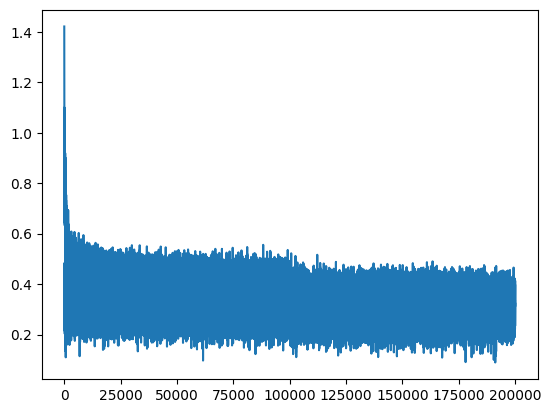

In [25]:
plt.plot(lossi)

(array([  9.,  17.,  22.,  33.,  43.,  58.,  66.,  90., 108., 106., 131.,
        120., 148., 143., 140., 142., 171., 161., 169., 207., 151., 200.,
        181., 182., 173., 191., 195., 194., 213., 189., 178., 157., 189.,
        165., 184., 185., 190., 173., 163., 123., 123., 115., 121., 106.,
         81.,  61.,  55.,  36.,  27.,  15.]),
 array([-0.96731734, -0.92870989, -0.89010244, -0.85149498, -0.81288753,
        -0.77428008, -0.73567262, -0.69706517, -0.65845772, -0.61985026,
        -0.58124281, -0.54263536, -0.50402791, -0.46542045, -0.426813  ,
        -0.38820555, -0.34959809, -0.31099064, -0.27238319, -0.23377573,
        -0.19516828, -0.15656083, -0.11795337, -0.07934592, -0.04073847,
        -0.00213102,  0.03647644,  0.07508389,  0.11369134,  0.1522988 ,
         0.19090625,  0.2295137 ,  0.26812116,  0.30672861,  0.34533606,
         0.38394352,  0.42255097,  0.46115842,  0.49976588,  0.53837333,
         0.57698078,  0.61558823,  0.65419569,  0.69280314,  0.73141059,
 

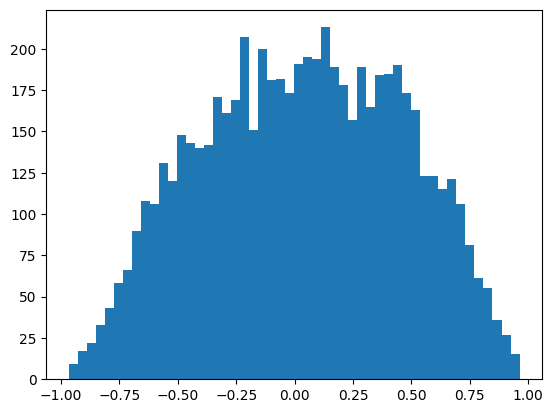

In [94]:
plt.hist(h.view(-1).tolist(), 50)

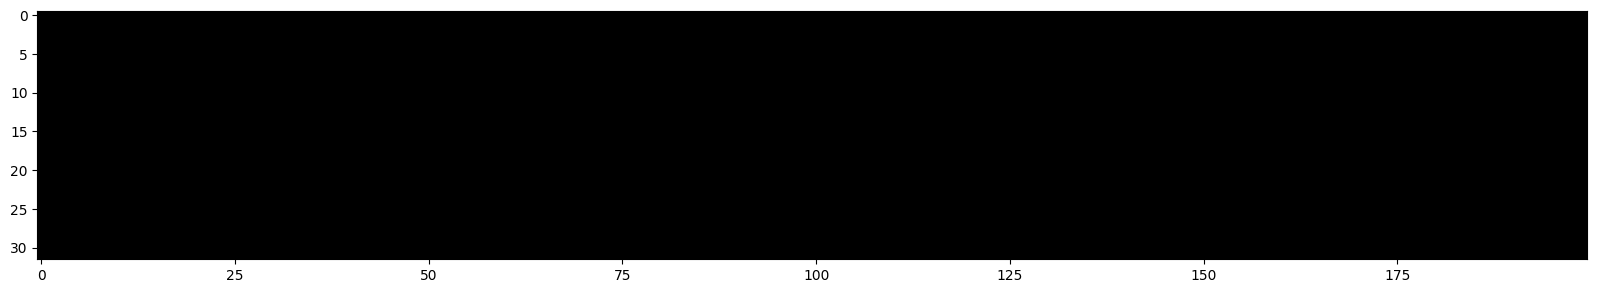

In [95]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")

In [118]:
@torch.no_grad()
def split_loss(split):
  x, y ={"train": (Xtr, Ytr),
         "val" : (Xdev, Ydev),
          "test": (Xte, Yte)
         } [split]
  emb = C[x] # (embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1# + b1 # Hidden layer pre-activation

  hpreact = (hpreact - bnmean_running) / bnstd_running
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, y) # loss function
  print(split, loss.item())



split_loss("train")
split_loss("val")



train 2.138253688812256
val 2.1841068267822266


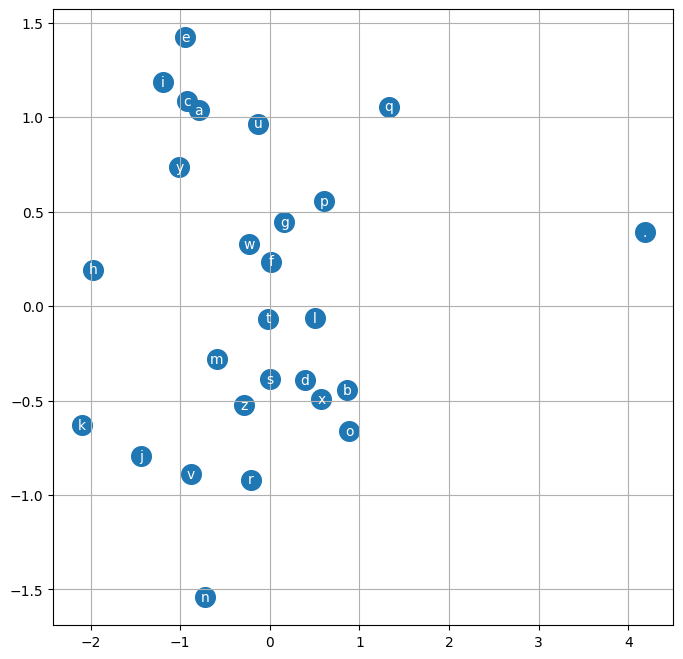

In [30]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [61]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

tex.
maloullissio.
jolivan.
maimittaigh.
kayk.
katha.
ster.
peejahsi.
gotas.
mcki.
jakoussephed.
jen.
emma.
sadeu.
niaviyah.
fobs.
malynn.
beth.
lus.
kash.


In [124]:
############# Organized #################

In [176]:
class Linear:
  def __init__(self, fan_in, fan_out, bias = True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] if self.bias is None else [self.weight, self.bias]
    # return [self.weight] + ([] if self.bias is None else [self.bias])

In [177]:
class BatchNorm1d:
  def __init__(self,dim, eps=1e-5, momentum = 0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    #parameters
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers
    self.mean_running = torch.zeros(dim)
    self.std_running = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      mean = x.mean(0, keepdim = True)
      std = x.std(0, keepdim = True)
    else:
      mean = self.mean_running
      std = self.std_running
    xhat = (x - mean) / torch.sqrt(std + self.eps)
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.mean_running = (1-self.momentum) * self.mean_running + self.momentum * mean
        self.std_running = (1-self.momentum) * self.std_running + self.momentum * std
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [178]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [224]:
n_emdb = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_emdb), generator=g)
layers = [
  Linear(n_emdb * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

172697


In [225]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]  # embed the characters into vectors
  x = emb.view(emb.shape[0], -1)  # concatenate the vectors
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)  # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad()

  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0:
    print(f"{i}/{max_steps}: Loss = {loss.item():.4f}")
  lossi.append(loss.log10().item())
  break

0/200000: Loss = 3.2914


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

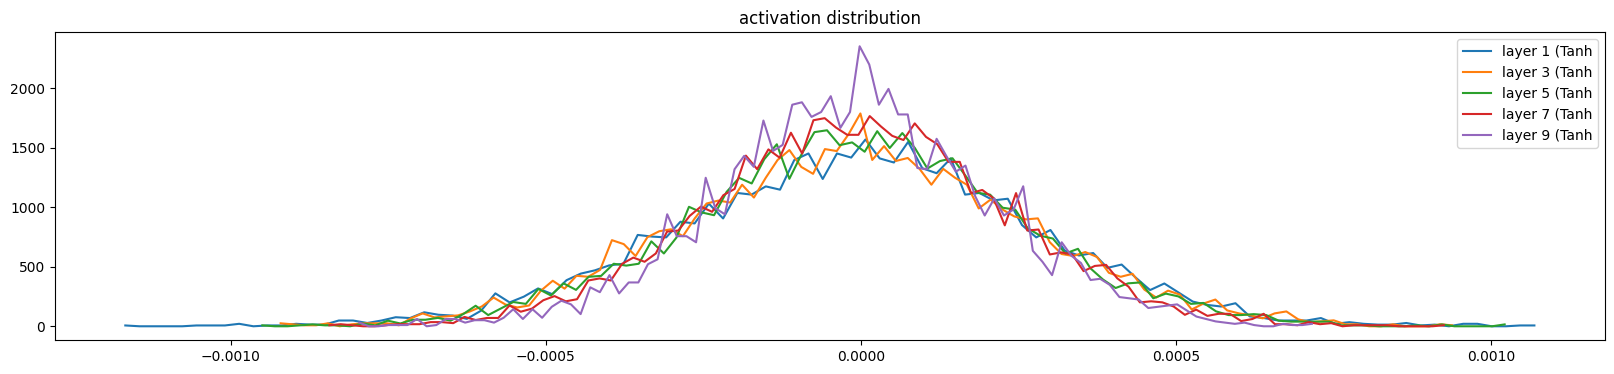

In [227]:

      # visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [166]:

with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
plt.plot(lossi)
plt.hist(h.view(-1).tolist(), 50)
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest")


@torch.no_grad()
def split_loss(split):
  x, y = {"train": (Xtr, Ytr),
          "val": (Xdev, Ydev),
          "test": (Xte, Yte)
          }[split]
  emb = C[x]  # (embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
  hpreact = embcat @ W1  # + b1 # Hidden layer pre-activation

  hpreact = (hpreact - bnmean_running) / bnstd_running
  hpreact = bngain * hpreact + bnbias

  h = torch.tanh(hpreact)  # hidden layer
  logits = h @ W2 + b2  # output layer
  loss = F.cross_entropy(logits, y)  # loss function
  print(split, loss.item())


split_loss("train")
split_loss("val")

# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

  out = []
  context = [0] * block_size  # initialize with all ...
  while True:
    emb = C[torch.tensor([context])]  # (1,block_size,d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
12097
0/50000: Loss = 3.3239


KeyboardInterrupt: 